In [128]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.table import Table, QTable, vstack
from astropy.coordinates import match_coordinates_sky, SkyCoord, Distance
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

get_ipython().run_line_magic('matplotlib', 'inline')

Reading fits files:

In [129]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

spt1 = Table.read('2500d_cluster_sample_Bocquet19.fits', format = 'fits')
spt2 = Table.read('sptecs_catalog_oct919.fits', format = 'fits')
spt = vstack([spt1, spt2], join_type='inner')
rm = Table.read('y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt20_vl50_catalog.fit', format = 'fits')

spt_id, spt_z = spt['SPT_ID'], spt['REDSHIFT']
spt_ra_dec = SkyCoord(ra = spt['RA'] * u.degree, dec = spt['DEC'] * u.degree, distance = Distance(z = spt_z, cosmology = cosmo))

rm_id, rm_z, rm_chisq = rm['MEM_MATCH_ID'], rm['Z_LAMBDA'], np.array(rm['LAMBDA_CHISQ'])
rm_ra_dec = SkyCoord(ra = rm['RA'] * u.degree, dec = rm['DEC'] * u.degree, distance = Distance(z = rm_z, cosmology = cosmo))


Matching:

In [130]:
dict = {}
for i in range(len(spt_id)):   #z < 0.1
    ids = list(np.where(abs(spt_z[i]-rm_z) < 0.1)[0])
    if len(ids) != 0:
        dict[i] = ids
        
newdict = {}
for i in dict:   # ang < 10
    ids = list(np.where(spt_ra_dec[i].separation(rm_ra_dec[dict[i]]).arcmin < 10)[0])  
    if len(ids) != 0:
        newdict[i] = ids
        
for i in newdict:    # max lambda_chisq
    if len(newdict[i])>1:
        newdict[i] = newdict[i][np.where(rm_chisq[newdict[i]] == max(rm_chisq[newdict[i]]))[0][0]] 


In [131]:
spt_i, rm_j = list(newdict.keys()), list(newdict.values())
dist3d = []
for i in range(len(spt_i)):
    dist = spt_ra_dec[spt_i[i]].separation_3d(rm_ra_dec[rm_j[i]]).value
    dist3d.append(dist)
    

(-10, 1119)

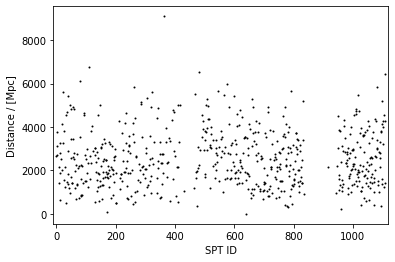

In [132]:
plt.errorbar(spt_i, dist3d, fmt = 'k.', ms = 2)#dist3d_err
plt.ylabel(r'Distance / [Mpc]')
plt.xlabel(r'SPT ID')
plt.xlim(-10, max(spt_i) + 10)



AGAIN

Reading data and matching:

In [133]:
spt = QTable([spt_id, spt_ra_dec, spt_z], names = ('id', 'ra, dec', 'z'))
rm = QTable([rm_id, rm_ra_dec, rm_z], names = ('id', 'ra, dec', 'z'))

idx, sep2d, dist3d = match_coordinates_sky(rm['ra, dec'], spt['ra, dec']) #the order counts, len(rm)>>len(spt)
zdist = abs(spt['z'][idx]-rm['z'])

bln = (sep2d.arcmin < 10) & (zdist < 0.1)
matches_raw = {'rm_spt_ids':   np.column_stack((np.where(bln)[0], idx[bln])), 
               'sep2d_arcmin': sep2d[bln].arcmin, 
               'z':            zdist[bln], 
               'dist3d_Mpc':   dist3d[bln].value}
rm_m_ids, spt_m_ids = matches_raw['rm_spt_ids'].T
rm_m_chisq = rm_chisq[bln]

In [134]:
matches = {'rm_spt_ids':[], 'sep2d_arcmin':[], 'z': [], 'dist3d_Mpc':[]}
for i in range(len(spt_m_ids)):
    result = np.where(spt_m_ids == spt_m_ids[i])[0]
    if len(result)==1:
        matches['rm_spt_ids'].append(list(matches_raw['rm_spt_ids'][result[0]]))
        matches['sep2d_arcmin'].append(matches_raw['sep2d_arcmin'][result[0]]) 
        matches['z'].append(matches_raw['z'][result[0]])
        matches['dist3d_Mpc'].append(matches_raw['dist3d_Mpc'][result[0]])
    if len(result)>1:
        rm_new_m = rm_m_ids[result[np.where(np.array(rm_m_chisq[result]) == np.amax(np.array(rm_m_chisq[result])))]]
        new_id = np.where(matches_raw['rm_spt_ids'] == rm_new_m)[0][0]
        matches['rm_spt_ids'].append(list(matches_raw['rm_spt_ids'][new_id]))
        matches['sep2d_arcmin'].append(matches_raw['sep2d_arcmin'][new_id]) 
        matches['z'].append(matches_raw['z'][new_id])
        matches['dist3d_Mpc'].append(matches_raw['dist3d_Mpc'][new_id])
        

spt_ids = np.array(matches['rm_spt_ids']).T[1]
dist3d_m = np.array(matches['dist3d_Mpc'])
dist3d_err = np.sqrt(np.sum(dist3d_m**2)/len(dist3d_m))



Plot:

(-10, 1119)

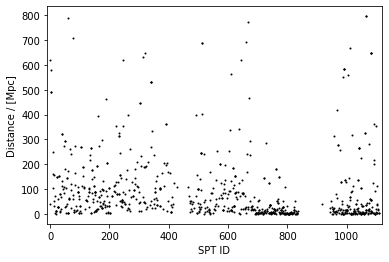

In [135]:
plt.errorbar(spt_ids, dist3d_m, fmt = 'k.', ms = 2)#dist3d_err
plt.ylabel(r'Distance / [Mpc]')
plt.xlabel(r'SPT ID')
plt.xlim(-10, max(spt_ids) + 10)

# Rayleigh Distribution:
$$P(x) = \frac{x}{\sigma^2}\mathrm{e}^{-0.5({x}/{\sigma})^2} \text{ and } \log(P(x)) = -2\log(\sigma) - \frac{x^2}{2\sigma ^2} + \log(x)$$



In [136]:
def log_prior(theta):
    H0, Om0, Tcmb0 = theta
    if 0 < H0 < 150 and 0.0 < Om0 < 2.0 and 2 < Tcmb0 < 3:
        return 0.0
    return -np.inf

def log_likelihood(theta, z, dist3d, dist3d_err):
    err = dist3d_err
    logl = np.sum(- 2 * np.log(err) - dist3d**2/2./err**2 + np.log(dist3d))
    return logl

def log_posterior(theta, z, dist3d, dist3d_err):
    lprio = log_prior(theta)
    if not np.isfinite(lp):
        return - np.inf
    logl = log_likelihood(theta, z, dist3d, dist3d_err)
    logpos = logl + lprior
    return logpos, lprior, logl